Прогнозирование Trans-MAF регулярных временных рядов.

## Imports

In [2]:
import json
import os
import pickle
import sys
import warnings

sys.path.append('../pytorch-ts')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import torch
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import MultivariateEvaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from pts import Trainer
from pts.model.transformer_tempflow import TransformerTempFlowEstimator

In [17]:
warnings.filterwarnings('ignore')

## Read Datasets

In [10]:
exchange = get_dataset("exchange_rate", regenerate=False)

solar = get_dataset("solar_nips", regenerate=False)

electricity = get_dataset("electricity_nips", regenerate=False)

In [13]:
# electricity
electricity_train_grouper = MultivariateGrouper(
    max_target_dim=min(2000, int(electricity.metadata.feat_static_cat[0].cardinality))
    )

electricity_test_grouper = MultivariateGrouper(
    num_test_dates=int(len(electricity.test) / len(electricity.train)), 
    max_target_dim=min(2000, int(electricity.metadata.feat_static_cat[0].cardinality))
    )

# solar
solar_train_grouper = MultivariateGrouper(
    max_target_dim=min(2000, int(solar.metadata.feat_static_cat[0].cardinality))
    )

solar_test_grouper = MultivariateGrouper(
    num_test_dates=int(len(solar.test) / len(solar.train)), 
    max_target_dim=min(2000, int(solar.metadata.feat_static_cat[0].cardinality))
    )

# exchange
exchange_train_grouper = MultivariateGrouper(
    max_target_dim=min(2000, int(exchange.metadata.feat_static_cat[0].cardinality))
    )

exchange_test_grouper = MultivariateGrouper(
    num_test_dates=int(len(exchange.test) / len(exchange.train)), 
    max_target_dim=min(2000, int(exchange.metadata.feat_static_cat[0].cardinality))
    )

In [14]:
# solar
solar_dataset_train = list(solar_train_grouper(solar.train))
solar_dataset_train *= 100 
solar_dataset_test = solar_test_grouper(solar.test)

# electricity
electricity_dataset_train = list(electricity_train_grouper(electricity.train))
electricity_dataset_train *= 100 
electricity_dataset_test = electricity_test_grouper(electricity.test)

# exchange
exchange_dataset_train = list(exchange_train_grouper(exchange.train))
exchange_dataset_train *= 100 
exchange_dataset_test = exchange_test_grouper(exchange.test)

In [18]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

## Train models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Solar

#### Train

In [18]:
%%time 

# init estimator
estimator = TransformerTempFlowEstimator(
    input_size=278,
    target_dim=int(solar.metadata.feat_static_cat[0].cardinality),
    prediction_length=solar.metadata.prediction_length,
    context_length=solar.metadata.prediction_length * 4,
    flow_type='MAF',
    dequantize=True,
    freq=solar.metadata.freq,
    trainer=Trainer(
        device='cpu',
        epochs=14,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

# train
predictor = estimator.train(
    solar_dataset_train, 
    num_workers=4
    )

  0%|          | 0/99 [00:00<?, ?it/s]

/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/elise

CPU times: user 5min 24s, sys: 2min 24s, total: 7min 49s
Wall time: 13min 26s


In [19]:
# save model

torch.save(predictor, './reports/maf/models/estimator__solar.ckpt')

#### Predict

In [21]:
# upload trained predictor
predictor = torch.load('./reports/maf/models/estimator__solar.ckpt')

# init evaluator
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20)/20.0)[1:],
    target_agg_funcs={'sum': np.sum}
)

# prediction
forecast_it, ts_it = make_evaluation_predictions(
    dataset=solar_dataset_test,
    predictor=predictor,
    num_samples=20
)

forecasts = list(forecast_it)
targets = list(ts_it)

# calculate metrics
agg_metric, _ = evaluator(
    targets, forecasts, num_series=len(solar_dataset_test)
    )

Running evaluation: 7it [00:00, 207.99it/s]
Running evaluation: 7it [00:00, 236.29it/s]
Running evaluation: 7it [00:00, 245.66it/s]
Running evaluation: 7it [00:00, 250.48it/s]
Running evaluation: 7it [00:00, 261.31it/s]
Running evaluation: 7it [00:00, 252.20it/s]
Running evaluation: 7it [00:00, 255.92it/s]
Running evaluation: 7it [00:00, 252.52it/s]
Running evaluation: 7it [00:00, 217.82it/s]
Running evaluation: 7it [00:00, 239.20it/s]
Running evaluation: 7it [00:00, 228.68it/s]
Running evaluation: 7it [00:00, 238.04it/s]
Running evaluation: 7it [00:00, 227.15it/s]
Running evaluation: 7it [00:00, 238.09it/s]
Running evaluation: 7it [00:00, 240.20it/s]
Running evaluation: 7it [00:00, 242.42it/s]
Running evaluation: 7it [00:00, 249.88it/s]
Running evaluation: 7it [00:00, 232.12it/s]
Running evaluation: 7it [00:00, 241.18it/s]
Running evaluation: 7it [00:00, 232.44it/s]
Running evaluation: 7it [00:00, 231.51it/s]
Running evaluation: 7it [00:00, 234.95it/s]
Running evaluation: 7it [00:00, 

#### Metrice

In [25]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

print("\nCRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS: 0.4359844196354769
ND: 0.5876701145552098
NRMSE: 1.0676794881211613
MSE: 1081.3333213548922

CRPS-Sum: 0.36896738329629547
ND-Sum: 0.502539992189743
NRMSE-Sum: 0.8135863982901882
MSE-Sum: 11784910.857142856


#### Save results

In [28]:
# metrics
with open('./reports/maf/predictions/agg_metrics__solar.json', 'w') as fp:
    json.dump(agg_metric, fp)

# targets
with open('reports/maf/predictions/targets__solar.pickle', 'wb') as handle:
    pickle.dump(targets, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# forecasts
with open('reports/maf/predictions/forecasts__solar.pickle', 'wb') as handle:
    pickle.dump(forecasts, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Actual/forecast visualisation

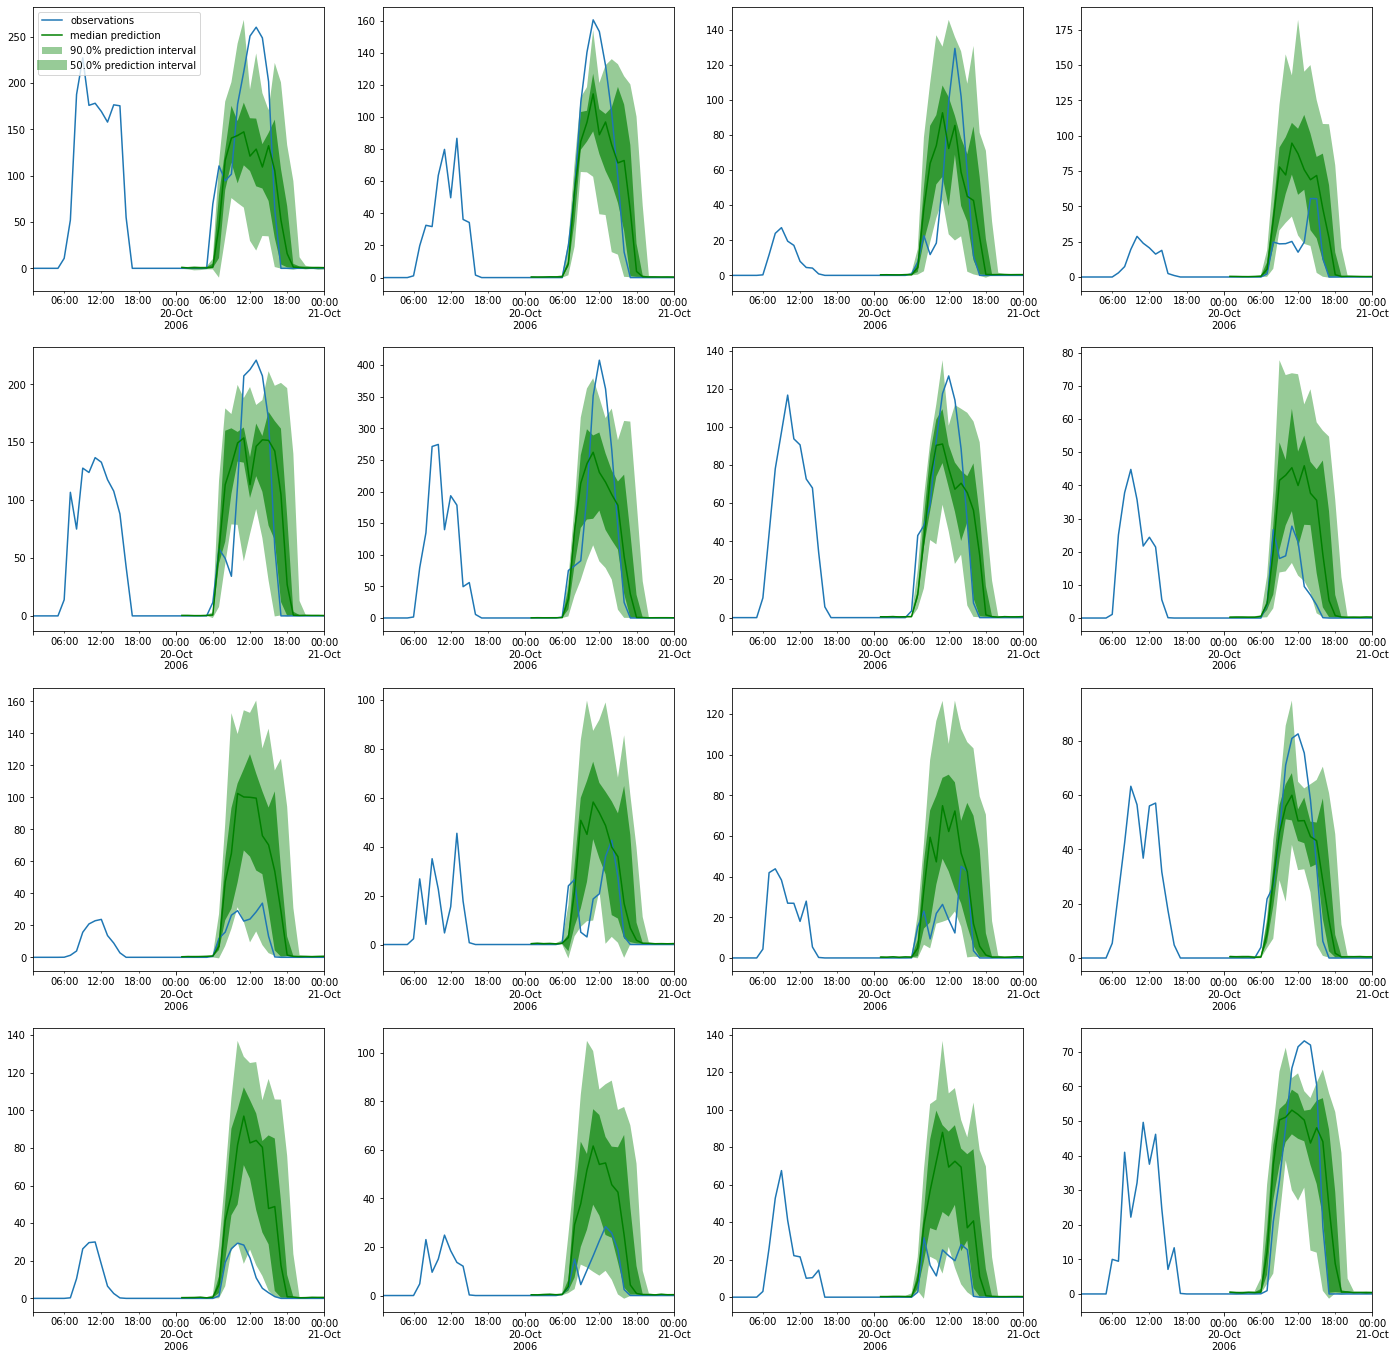

In [29]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=solar.metadata.prediction_length,
)
plt.show()

### Electricity

#### Train

In [24]:
# init estimator
estimator = TransformerTempFlowEstimator(
    input_size=744,
    target_dim=int(electricity.metadata.feat_static_cat[0].cardinality),
    prediction_length=electricity.metadata.prediction_length,
    context_length=electricity.metadata.prediction_length * 4,
    flow_type='MAF',
    dequantize=True,
    freq=electricity.metadata.freq,
    trainer=Trainer(
        device='cpu',
        epochs=14,
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

# train
predictor = estimator.train(
    electricity_dataset_train, 
    num_workers=4
    )

  0%|          | 0/99 [00:00<?, ?it/s]/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserial

In [25]:
# save model

torch.save(predictor, './reports/maf/models/estimator__electricity.ckpt')

#### Predict

In [26]:
# upload trained predictor
predictor = torch.load('./reports/maf/models/estimator__electricity.ckpt')

# init evaluator
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20)/20.0)[1:],
    target_agg_funcs={'sum': np.sum}
)

# prediction
forecast_it, ts_it = make_evaluation_predictions(
    dataset=electricity_dataset_test,
    predictor=predictor,
    num_samples=20
)

forecasts = list(forecast_it)
targets = list(ts_it)

# calculate metrics
agg_metric, _ = evaluator(
    targets, forecasts, num_series=len(electricity_dataset_test)
    )

Running evaluation: 7it [00:00, 249.91it/s]
Running evaluation: 7it [00:00, 51.81it/s]
Running evaluation: 7it [00:00, 269.65it/s]
Running evaluation: 7it [00:00, 275.43it/s]
Running evaluation: 7it [00:00, 240.96it/s]
Running evaluation: 7it [00:00, 214.72it/s]
Running evaluation: 7it [00:00, 218.61it/s]
Running evaluation: 7it [00:00, 180.93it/s]
Running evaluation: 7it [00:00, 203.31it/s]
Running evaluation: 7it [00:00, 222.15it/s]
Running evaluation: 7it [00:00, 216.03it/s]
Running evaluation: 7it [00:00, 228.52it/s]
Running evaluation: 7it [00:00, 267.42it/s]
Running evaluation: 7it [00:00, 253.31it/s]
Running evaluation: 7it [00:00, 270.16it/s]
Running evaluation: 7it [00:00, 263.65it/s]
Running evaluation: 7it [00:00, 245.94it/s]
Running evaluation: 7it [00:00, 237.84it/s]
Running evaluation: 7it [00:00, 262.06it/s]
Running evaluation: 7it [00:00, 251.94it/s]
Running evaluation: 7it [00:00, 249.47it/s]
Running evaluation: 7it [00:00, 259.72it/s]
Running evaluation: 7it [00:00, 2

#### Metrics

In [28]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

print("\nCRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS: 0.07277974147365758
ND: 0.09518466039977479
NRMSE: 0.9036976426403553
MSE: 467750.21709893673

CRPS-Sum: 0.03870780534142931
ND-Sum: 0.05031552798872197
NRMSE-Sum: 0.06906632772229736
MSE-Sum: 374027806.4761905


#### Save results

In [31]:
# metrics
with open('./reports/maf/predictions/agg_metrics__electricity.json', 'w') as fp:
    json.dump(agg_metric, fp)

# targets
with open('reports/maf/predictions/targets__electricity.pickle', 'wb') as handle:
    pickle.dump(targets, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# forecasts
with open('reports/maf/predictions/forecasts__electricity.pickle', 'wb') as handle:
    pickle.dump(forecasts, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Actual/forecast visualisation

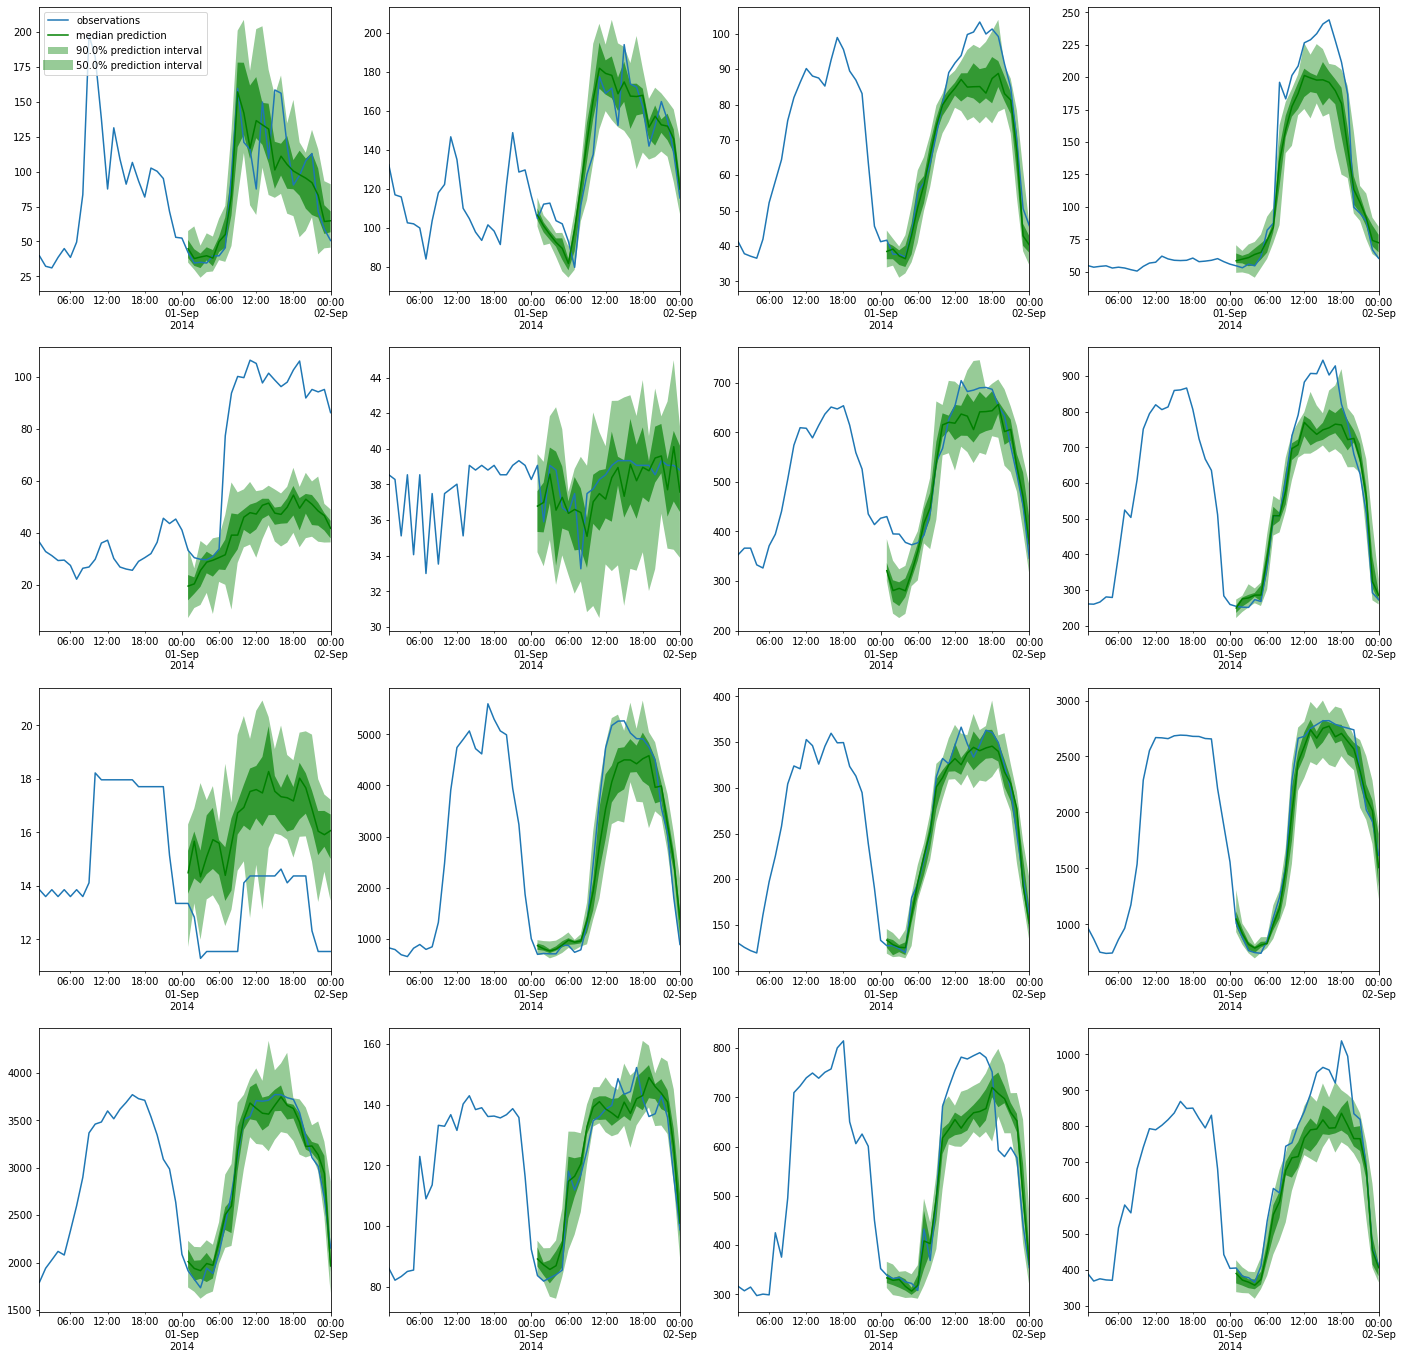

In [32]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=electricity.metadata.prediction_length,
)
plt.show()

### Echange

#### Train

In [20]:
exchange.metadata.freq

'1B'

In [21]:
exchange_freq = 'B'

In [55]:
# init estimator
estimator = TransformerTempFlowEstimator(
    input_size=28,
    target_dim=int(exchange.metadata.feat_static_cat[0].cardinality),
    prediction_length=exchange.metadata.prediction_length,
    context_length=exchange.metadata.prediction_length * 8,
    flow_type='MAF',
    dequantize=True,
    freq=exchange_freq,
    scaling=False,
    trainer=Trainer(
        device='cpu',
        epochs=14, 
        learning_rate=1e-3,
        num_batches_per_epoch=100,
        batch_size=64,
    )
)

# train
predictor = estimator.train(
    exchange_dataset_train, 
    num_workers=4
    )

  0%|          | 0/99 [00:00<?, ?it/s]

/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/multiprocessing/spawn.py:126: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  self = reduction.pickle.load(from_parent)
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/multiprocessing/spawn.py:126: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  self = reduction.pickle.lo

Notes:
- увеличение эпох ухудшает метрику
- scaling=False - улучшает 

- возможно что-то не то с данными
- context length * 2 ухудшает метрику


- context length * 8 незначительно улучшает метрику
- context length * 8 + epochs=40 не улучшает метрику

In [53]:
# save model

torch.save(predictor, './reports/maf/models/estimator__exchange.ckpt')

#### Predict

In [56]:
# upload trained predictor
predictor = torch.load('./reports/maf/models/estimator__exchange.ckpt')

# init evaluator
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20)/20.0)[1:],
    target_agg_funcs={'sum': np.sum}
)

# prediction
forecast_it, ts_it = make_evaluation_predictions(
    dataset=exchange_dataset_test,
    predictor=predictor,
    num_samples=40
)

forecasts = list(forecast_it)
targets = list(ts_it)

# calculate metrics
agg_metric, _ = evaluator(
    targets, forecasts, num_series=len(exchange_dataset_test)
    )

Running evaluation: 5it [00:00, 183.89it/s]
Running evaluation: 5it [00:00, 254.90it/s]
Running evaluation: 5it [00:00, 237.49it/s]
Running evaluation: 5it [00:00, 252.13it/s]
Running evaluation: 5it [00:00, 251.70it/s]
Running evaluation: 5it [00:00, 243.05it/s]
Running evaluation: 5it [00:00, 244.12it/s]
Running evaluation: 5it [00:00, 248.24it/s]
Running evaluation: 5it [00:00, 214.01it/s]


#### Metrics

In [58]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

print("\nCRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS: 0.3173006525863367
ND: 0.4662760994482768
NRMSE: 0.4847283175955831
MSE: 0.15542223622401558

CRPS-Sum: 0.3855639108476098
ND-Sum: 0.46130015090615456
NRMSE-Sum: 0.4563779852580202
MSE-Sum: 8.81750498453776


#### Save results

In [40]:
# metrics
with open('./reports/maf/predictions/agg_metrics__exchange.json', 'w') as fp:
    json.dump(agg_metric, fp)

# targets
with open('reports/maf/predictions/targets__exchange.pickle', 'wb') as handle:
    pickle.dump(targets, handle, protocol=pickle.HIGHEST_PROTOCOL)

# forecasts   
with open('reports/maf/predictions/forecasts__exchange.pickle', 'wb') as handle:
    pickle.dump(forecasts, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Actual/forecast visualisation

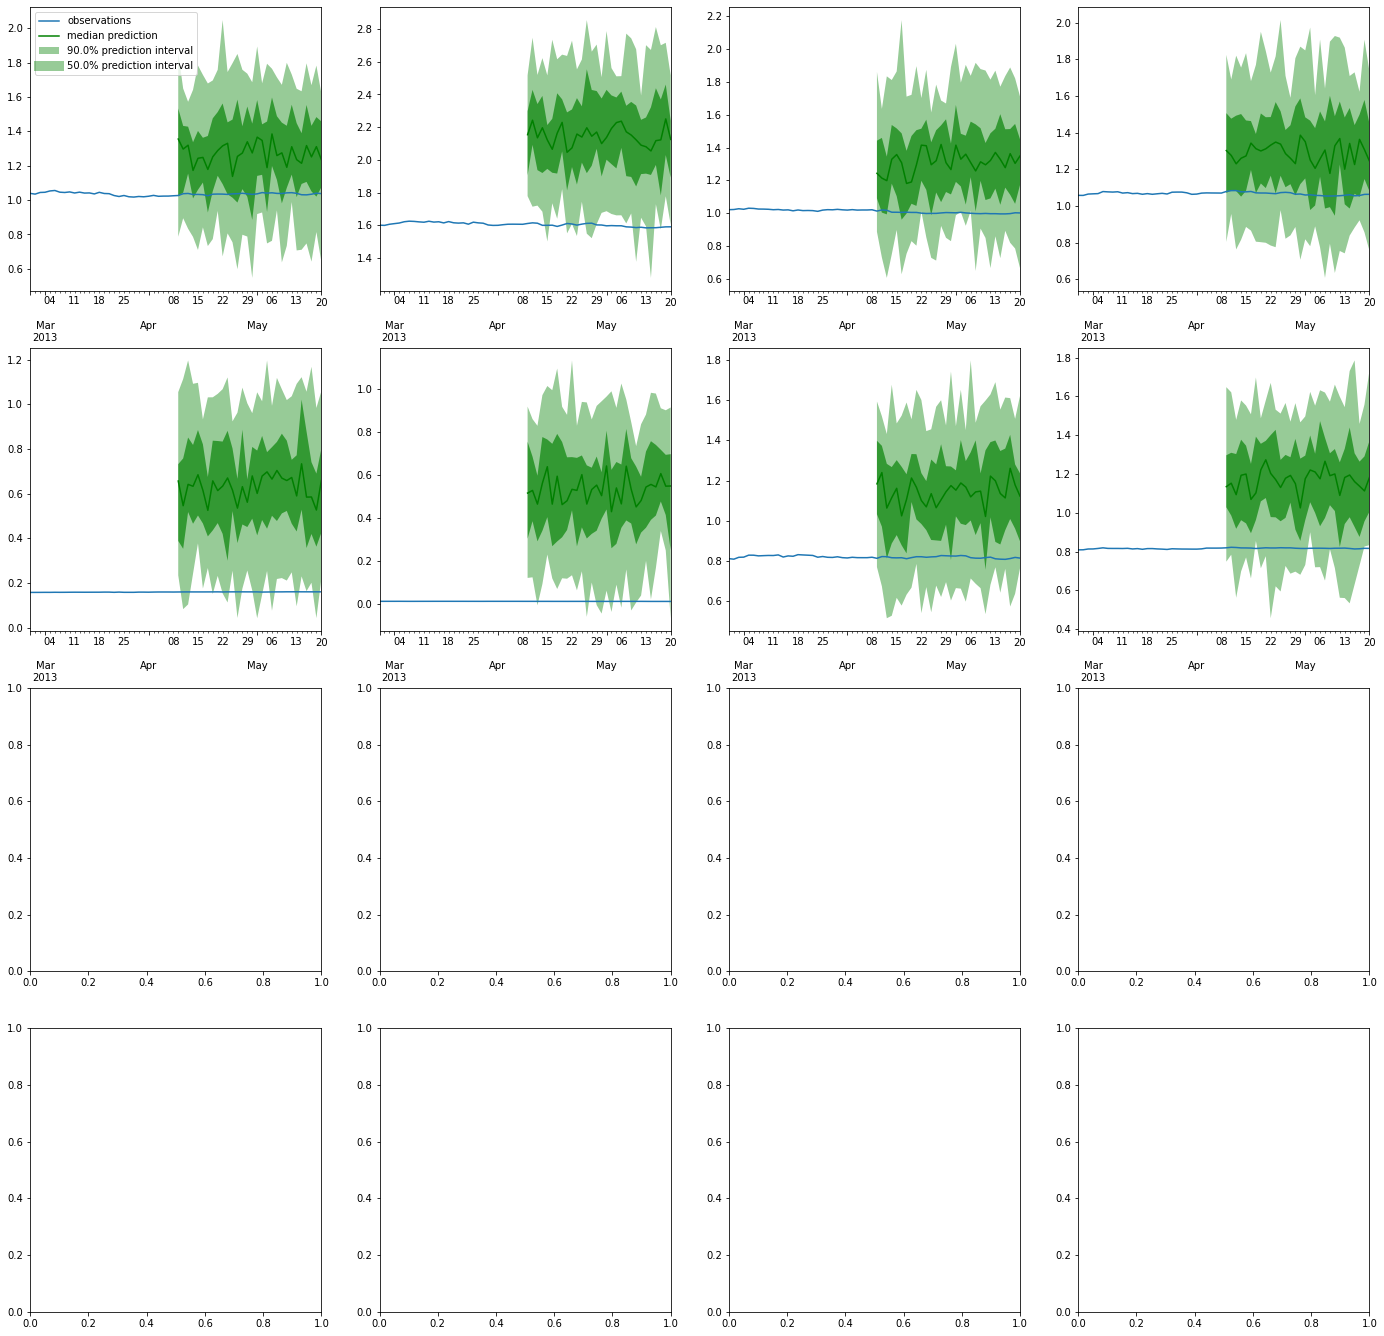

In [52]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=exchange.metadata.prediction_length,
)

plt.show()